# SINDy in Neuromancer

This tutorial demonstrates the use of [sparse identification of nonlinear dynamics (SINDy)](https://arxiv.org/abs/1509.03580) in Neuromancer. 

## SINDy for System Identification
SINDy is a machine learning model that uses sparse regression techniques to estimate the dynamics that guide time derivatives $\dot{X}$ from state variables $X$. SINDy does this by creating a library of candidate functions $\theta$, at which each state variable in $X$ is evaluated, and a matrix of coefficients $\Xi$. SINDy then uses linear regression to fit the coefficients in the equation $\dot{X} = \theta(X)\Xi$. SINDy aims to find as few nonzero coefficients as possible while still accurately describing the relationship between $X$ and $\dot{X}$.

<img src="figs/sindy.jpeg" width=600/>


### References
[1] [Brunton, Steven L. and Proctor, Joshua L. and Kutz, J. Nathan](https://arxiv.org/abs/1509.03580)

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [1]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode, library
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

Consider the [Thomas Attractor](https://en.wikipedia.org/wiki/Thomas%27_cyclically_symmetric_attractor) defined by the [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation): 

$$
 \frac{dx_0}{dt} = sin(x_1) - b x_0
$$
$$
 \frac{dx_1}{dt} = sin(x_2) - b x_1
$$
$$
 \frac{dx_2}{dt} = sin(x_0) - b x_2
$$

In this example we only have access to limited measurements of the system states $x$.

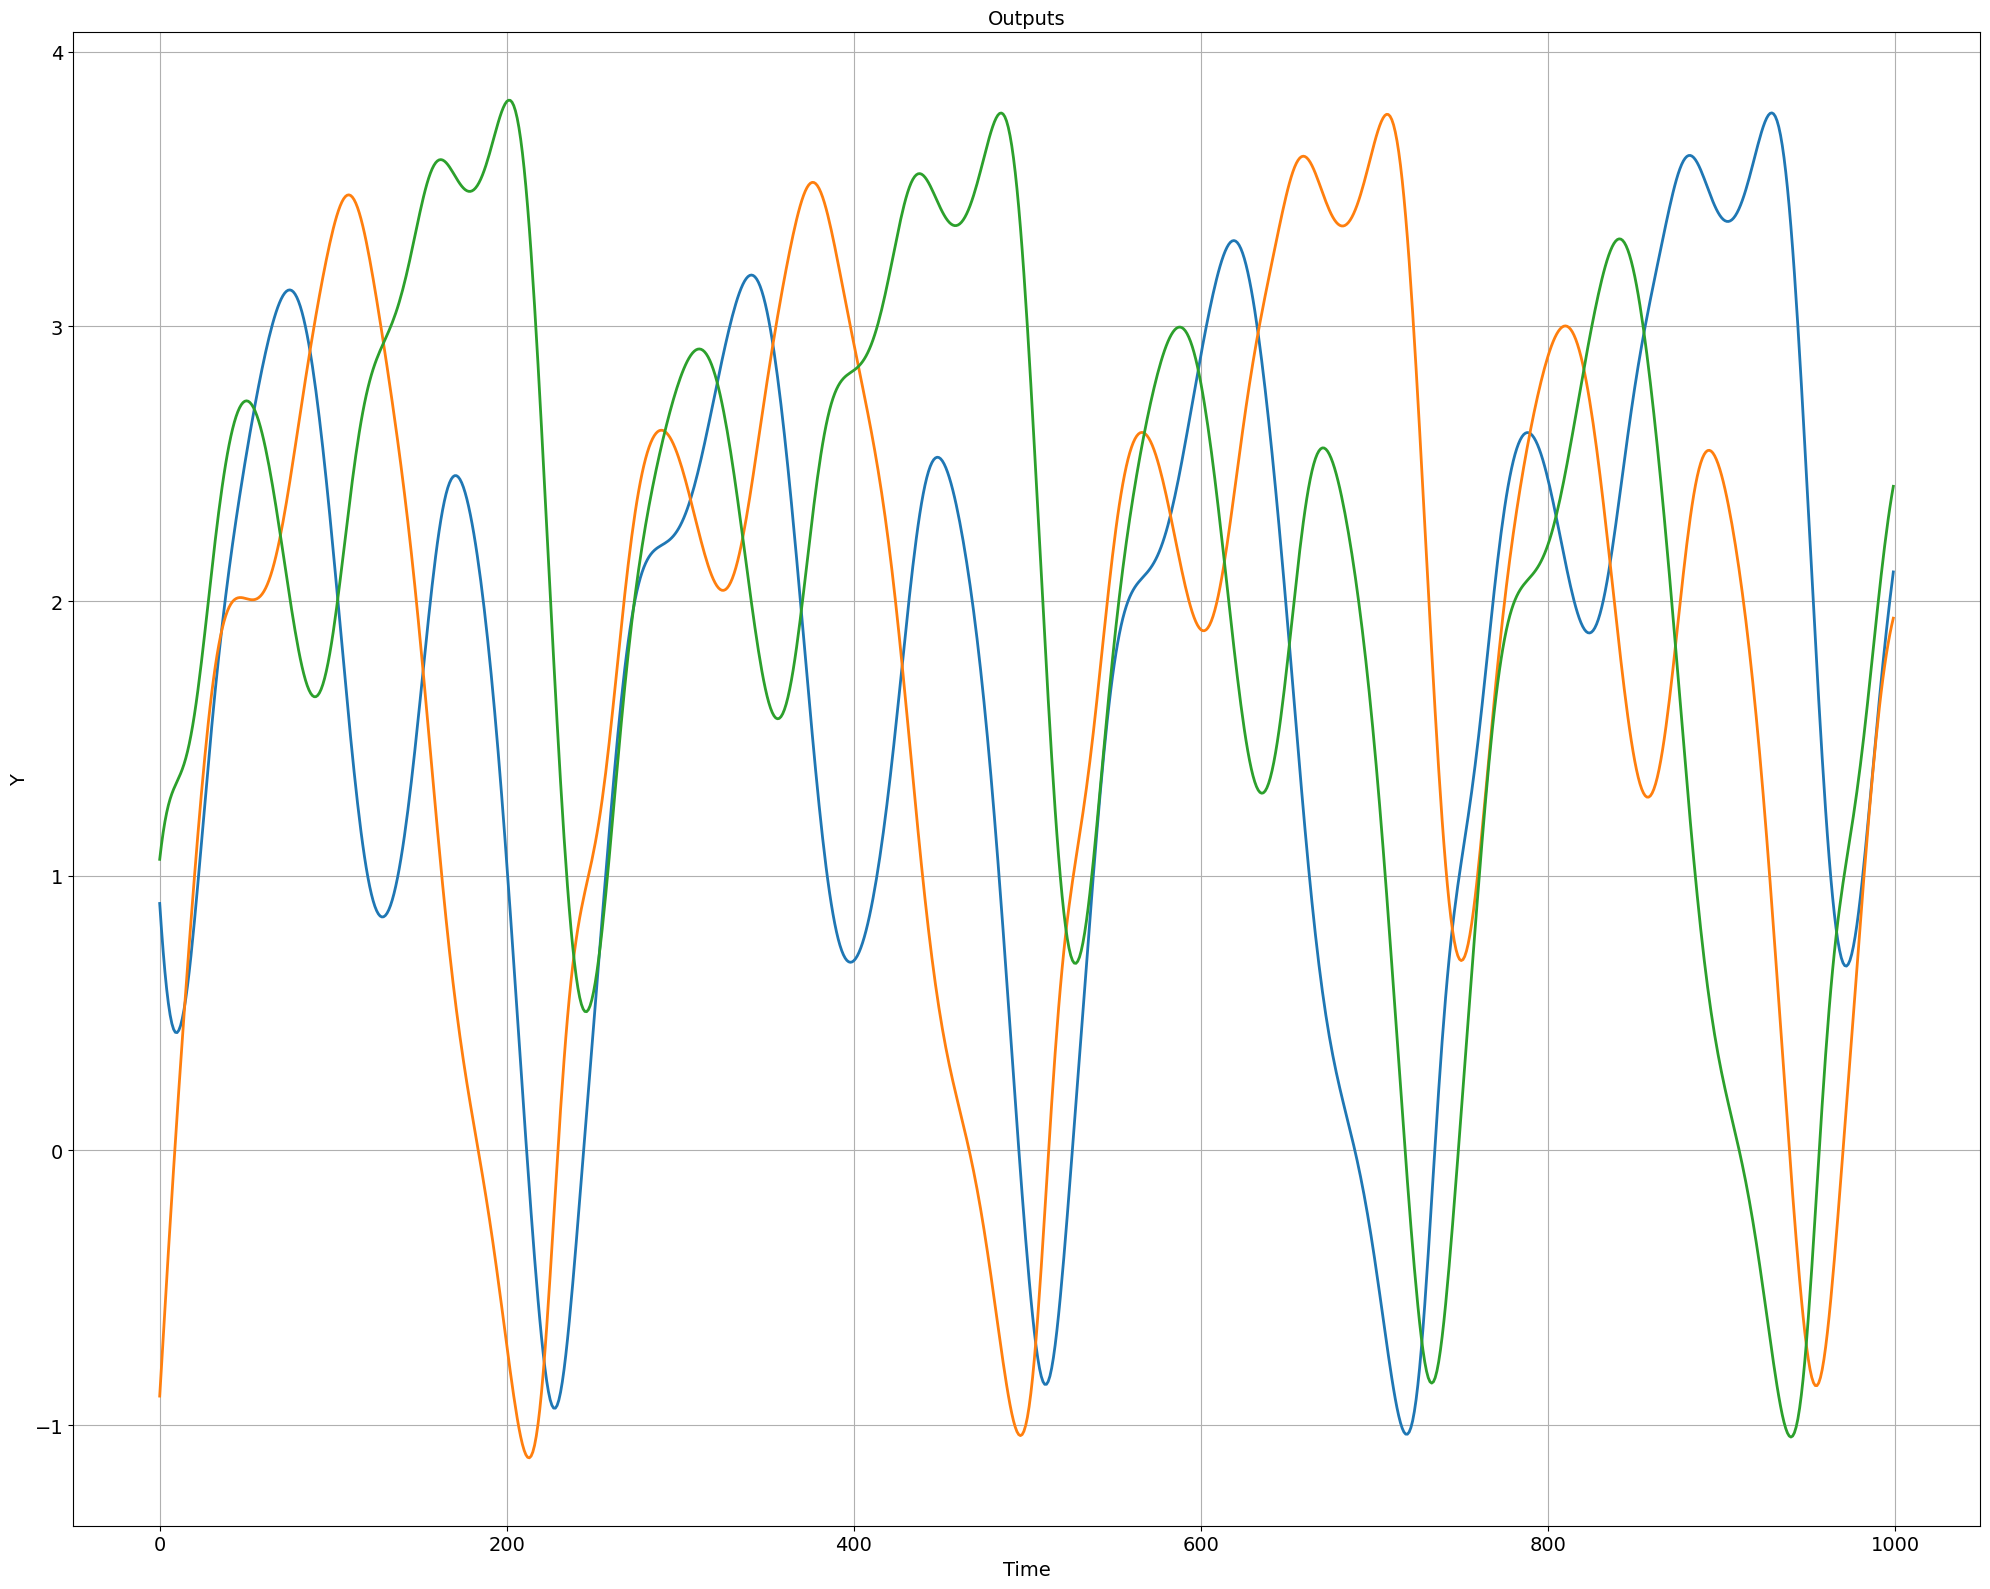

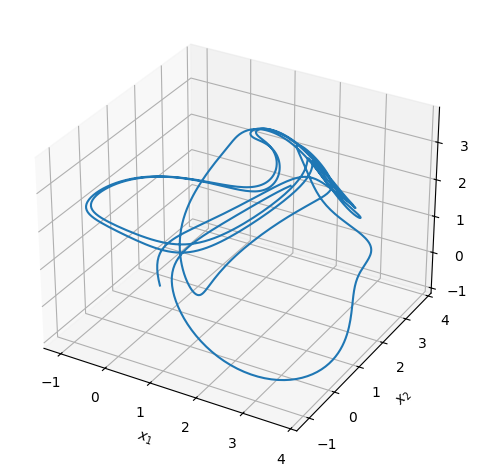

In [2]:
system = psl.systems['ThomasAttractor']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics to model: 
$$\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.


In [3]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data

In [4]:
nsim = 1000   # number of simulation steps in the dataset
nsteps = 10   # number of prediction horizon steps in the loss function
bs = 50     # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## Library Construction

Here, we create a library of candidate functions $\theta$. This library is a vector of functions: $$\big[f_0(X), f_1(X), \ldots, f_n(X)]$$ Our library will be evaluated for every data point in our dataset, giving us $\theta(X)$. The goal is to discover which linear combinations of functions within our library accurately describe the relationship between $X$ and $\dot{X}$. Thus, it is imperative that we select a library with ample expressiveness to represent all of the dynamics between our state variables $X$ and our derivatives $\dot{X}$. In most SINDy use cases, construction of the library of candidate functions is the most importance choice to make in the system identification process.

### Function Library

Neuromancer provides access to a function library class, which when given a list of functions, will store them within a vector, and provides an evaluate function so that the functions can easily be evaluated for all points within our data matrix. To construct any general function library, we will need to provide a list of functions that can be evaluated over the columns of our data matrix (this can be a regular `list` or an `np.ndarray`), an `int` number of input features, and (optionally) a `list` containing the names of our functions. When evaluating, the library expects the data matrix to be in the form of a `torch.Tensor`. The returned `torch.Tensor` from `FunctionLibrary.evaluate(X)` will have the shape of `(number of time steps in X, number of candidate functions)`.

In [5]:
candidate_functions = [lambda X: X[:,0]**2, lambda X: X[:,0], lambda X: X[:,2]**2, lambda X: 1, lambda X: torch.sin(X[:,1])]
names = ["x0^2", "x0", "x2^2", "1", "cos(x0)"]

theta = library.FunctionLibrary(candidate_functions, nx, names)
X = torch.tensor(modelSystem.simulate(nsim=nsim, ts=ts)['X'])

theta_X = theta.evaluate(X)
print(theta)
theta_X

x0^2, x0, x2^2, 1, cos(x0)


tensor([[ 0.8084,  0.8991,  1.1231,  1.0000, -0.7799],
        [ 0.6510,  0.8068,  1.2375,  1.0000, -0.7093],
        [ 0.5239,  0.7238,  1.3409,  1.0000, -0.6308],
        ...,
        [ 4.0129,  2.0032,  5.4763,  1.0000,  0.9528],
        [ 4.2261,  2.0557,  5.6674,  1.0000,  0.9429],
        [ 4.4362,  2.1062,  5.8464,  1.0000,  0.9334]])

The plot below shows $\theta(X)$.

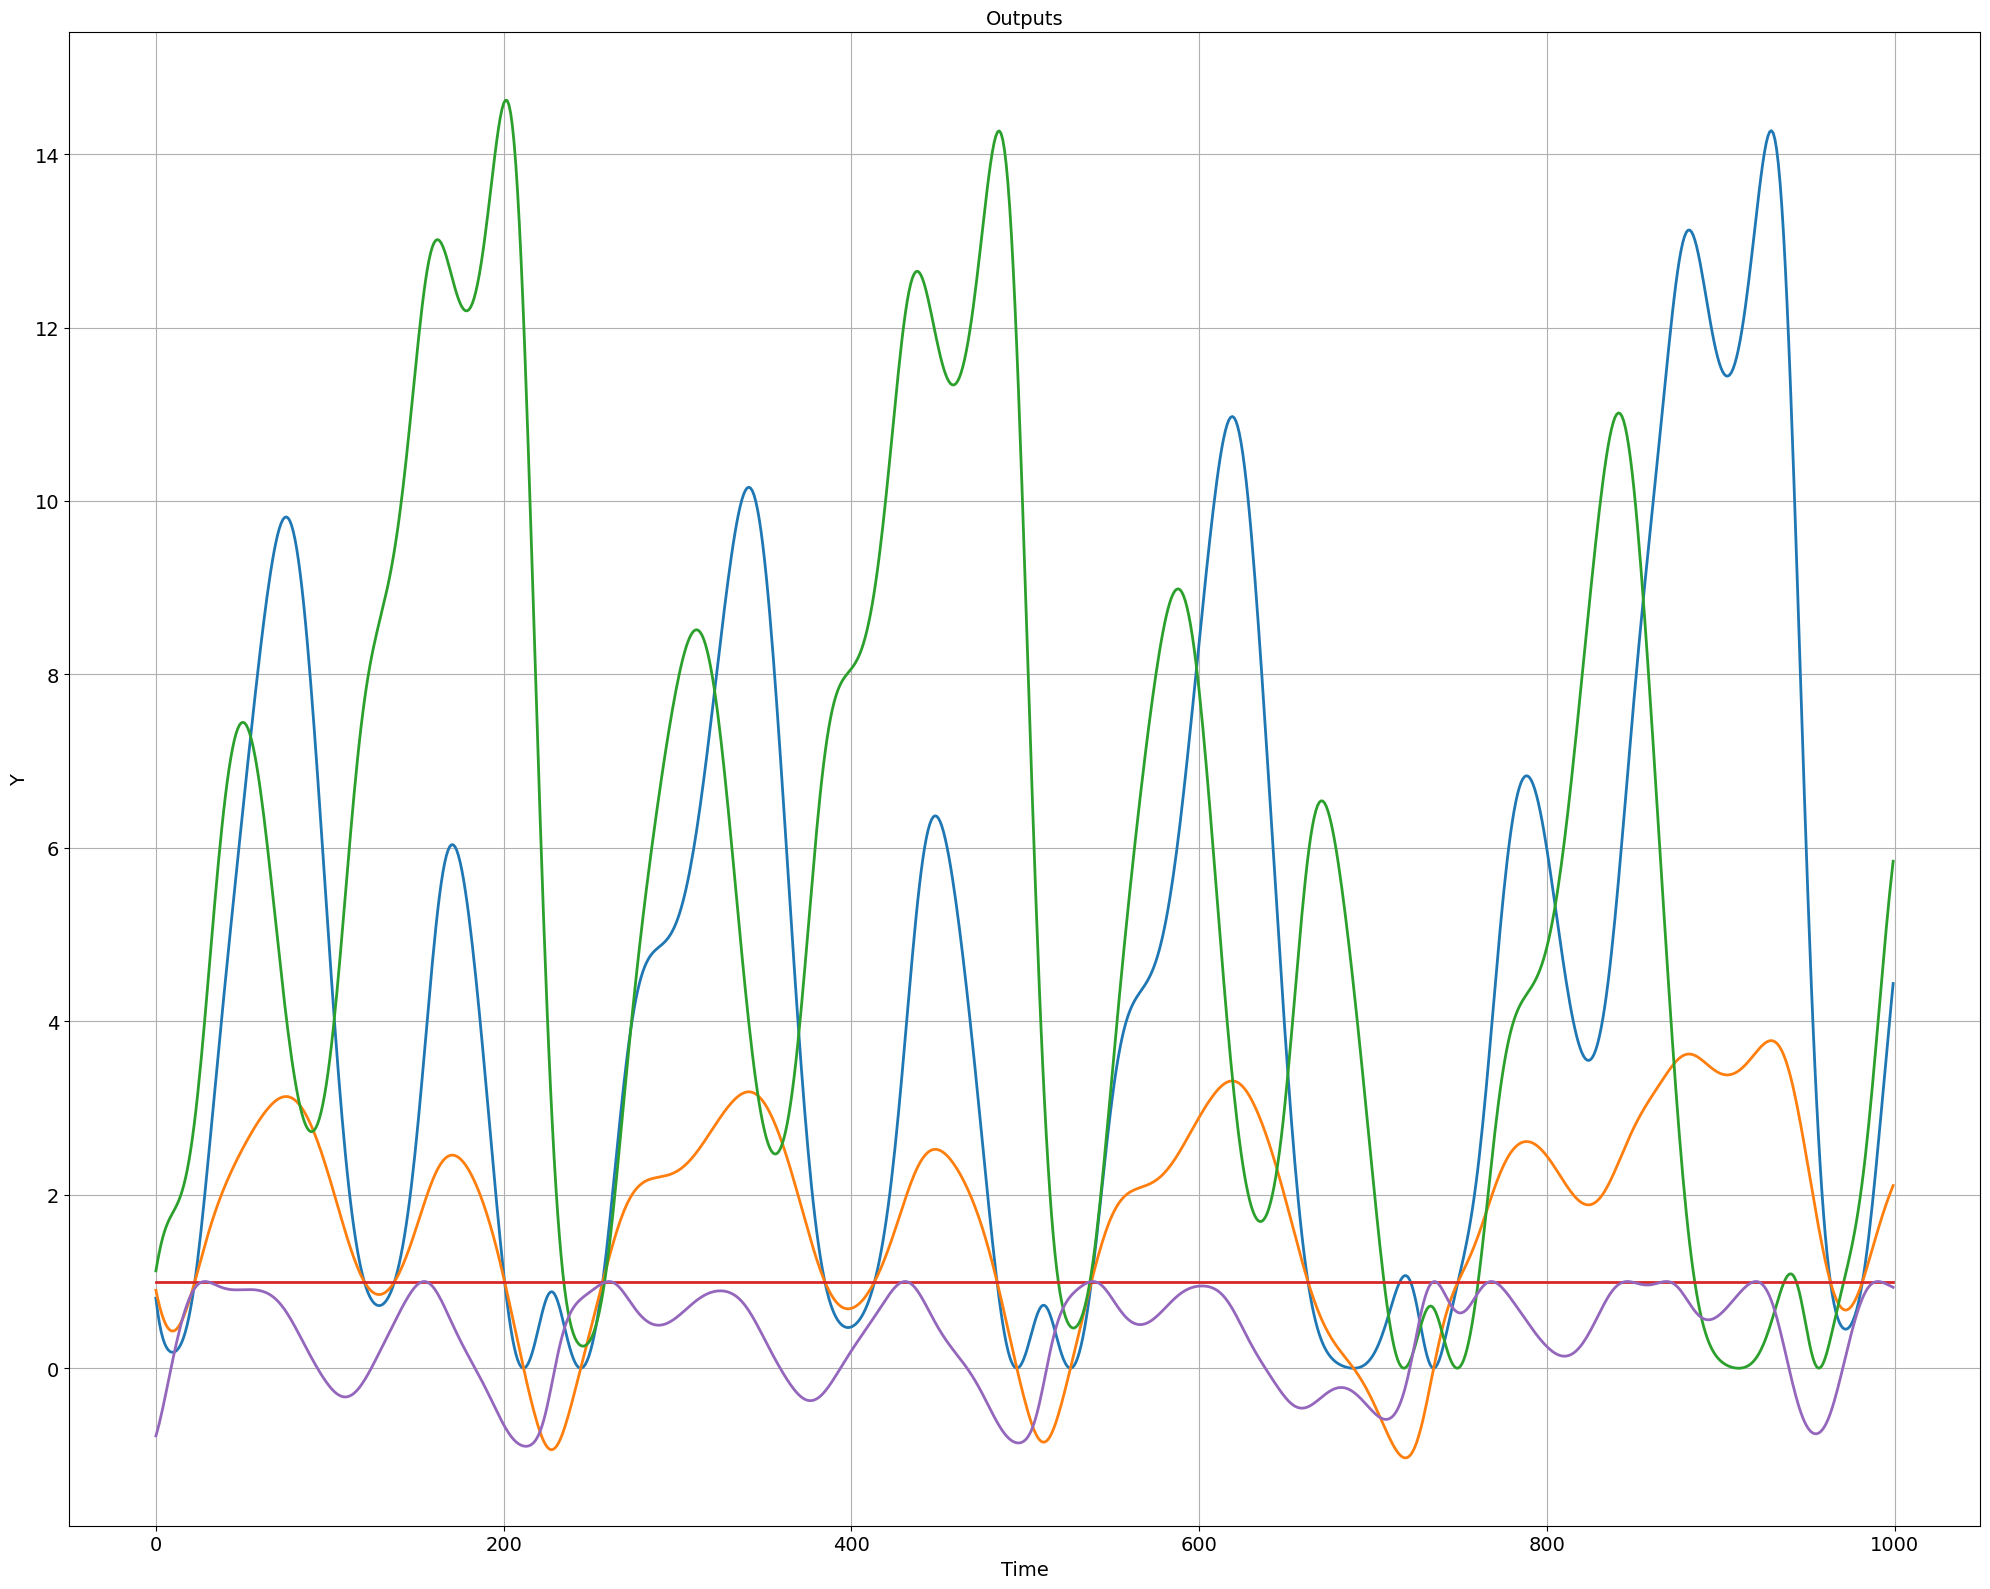

In [6]:
plot.pltOL(Y=theta_X)

Remember, our goal is to find linear combinations of our candidate functions that transform $X$ to $\dot{X}$, and use that information to project the trajectory of $X$ for some initial condition. For example, we know that $$\frac{dx_0}{dt} = sin(x_1) - bx_0.$$ So we could manually do this with our function library, and propagate these small changes in $x_0$ through time using our initial condition. You'll notice that when plotted, this is the same as the blue line in the original plot of our system. The goal of SINDy is to do this exact thing by using linear regression to find which functions in our library are active, and to find proper values for parameters such as $b$.

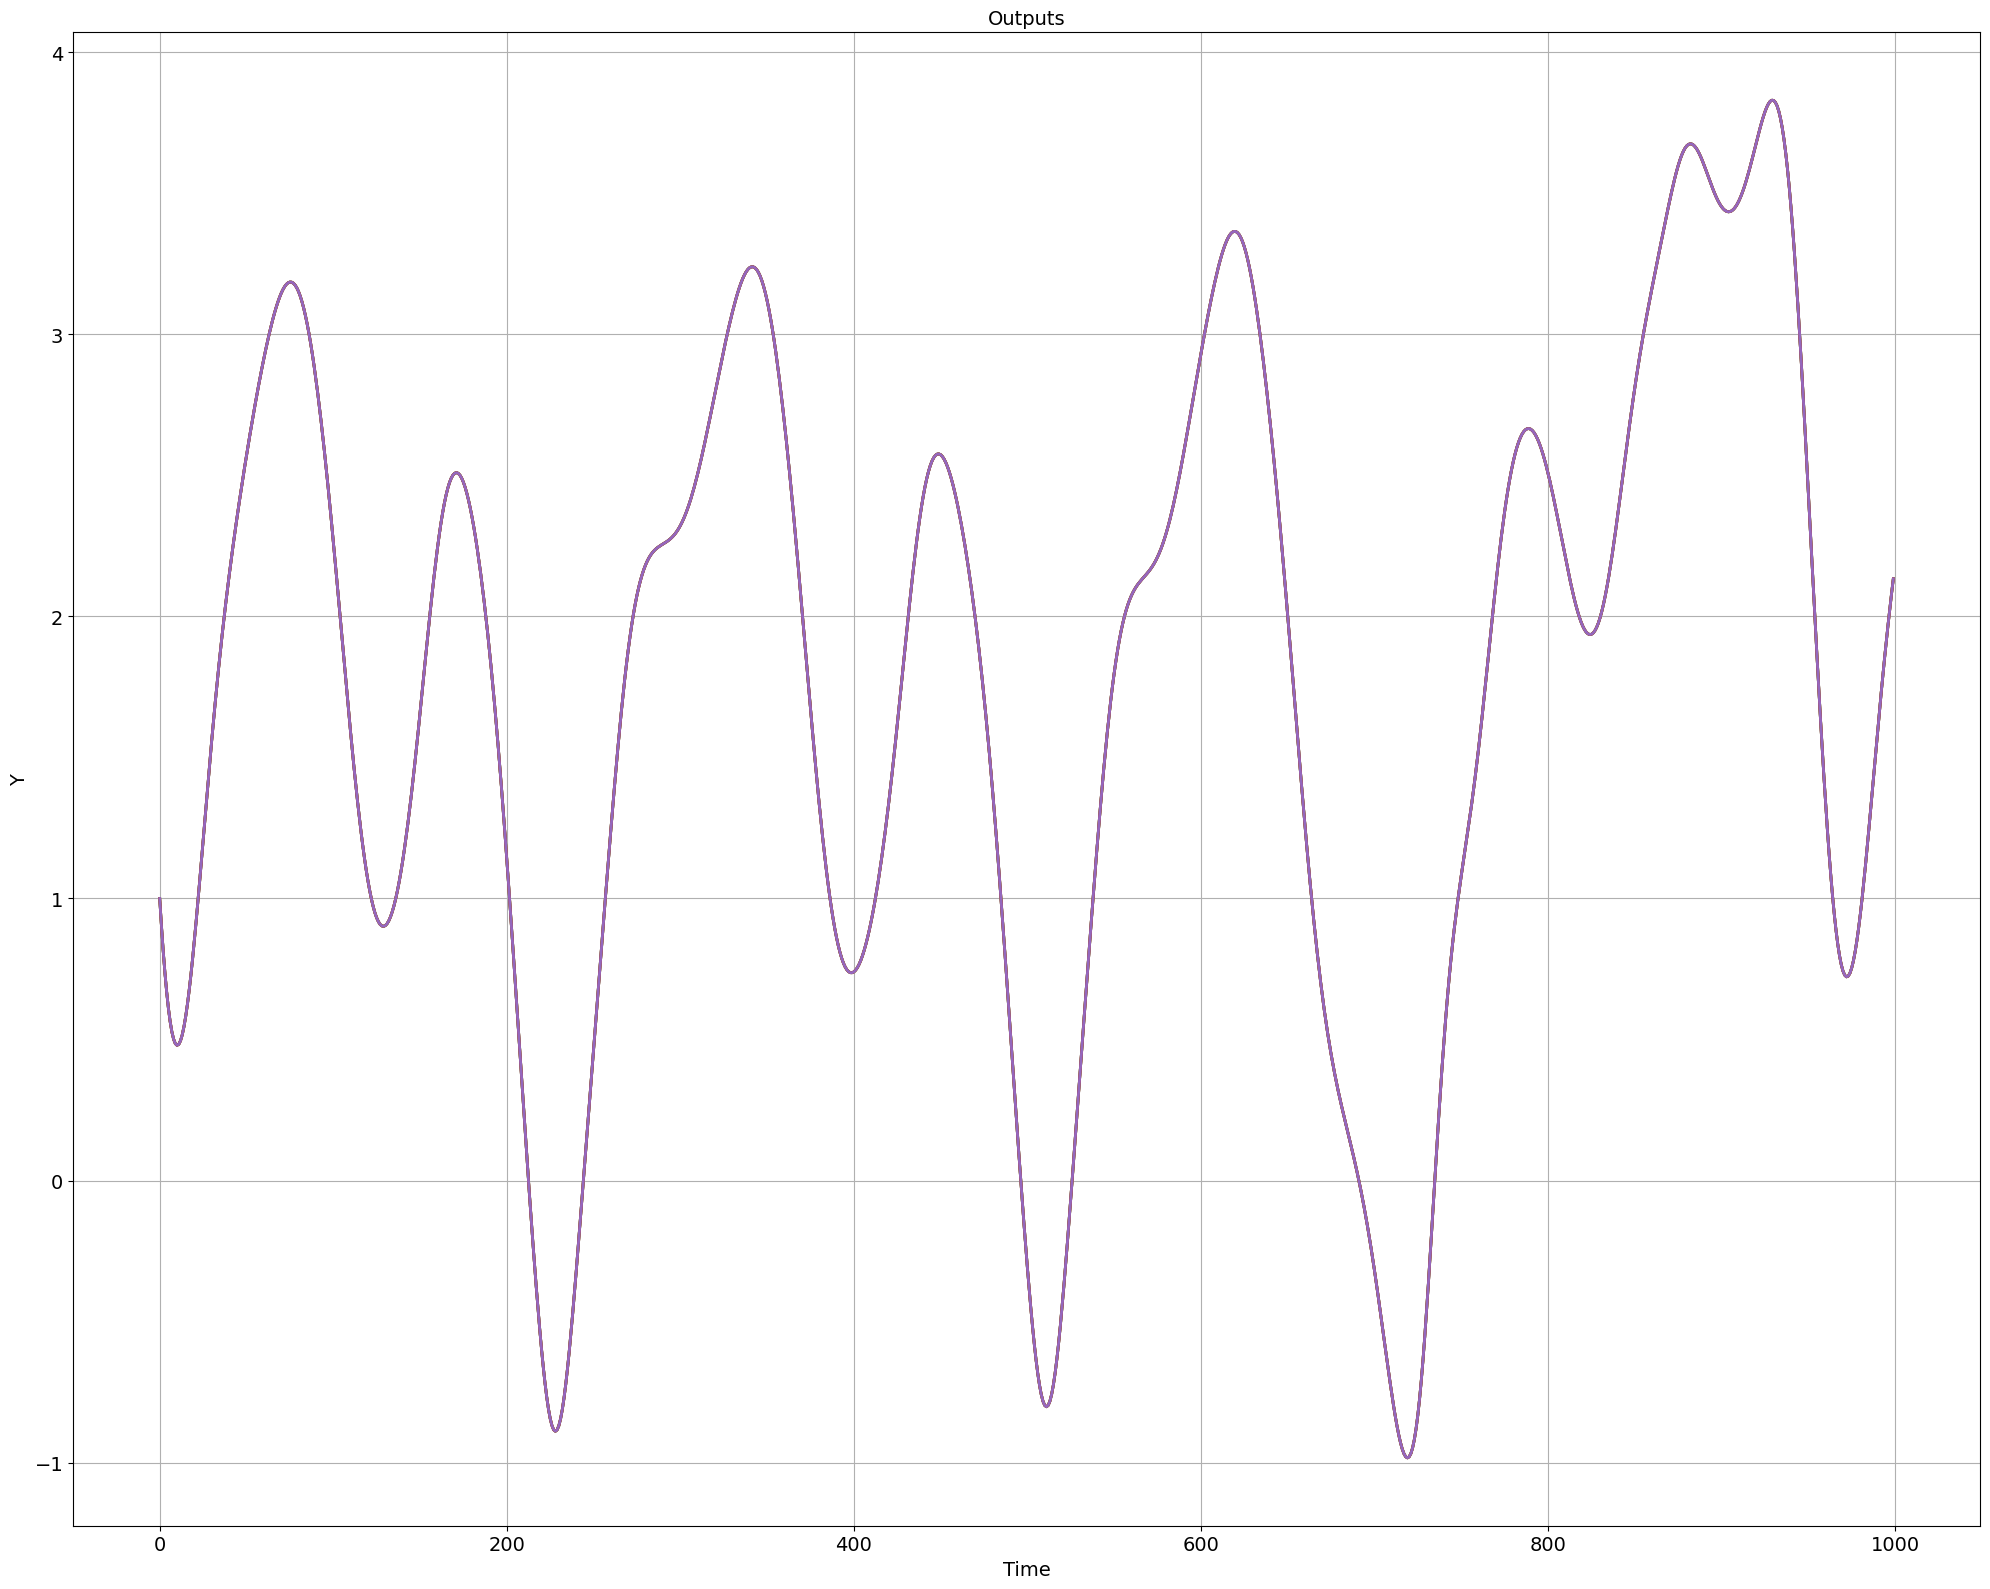

In [7]:
dx0_dt = theta_X[:,4] - float(modelSystem.b)*theta_X[:,1]
initial_x0 = float(modelSystem.x0[0])
x0 = torch.zeros((theta_X.shape))
x0[0] = initial_x0
step = 1
while step < theta_X.shape[0]:
    x0[step] = x0[step-1] + modelSystem.ts*dx0_dt[step-1]
    step += 1
plot.pltOL(Y=x0)

### Fourier Library

We start by constructing a Fourier library, which is based on the idea of the [Fourier series](https://en.wikipedia.org/wiki/Fourier_series). In this example, we know there will be some periodicity in our dynamics, and the Fourier series can expand periodic functions into linear combinations of trigonometric functions. When given the number of input features $n$ and a max frequency $m$, the Fourier library will be constructed with in the form: $$\big[sin(x_0), sin(2x_0), \ldots, sin(mx_0), \ldots, sin(x_n), \ldots, sin(mx_n), cos(x_0), \ldots, cos(mx_0), \ldots, cos(x_n), \ldots, cos(mx_n)]$$

Neuromancer provides the Fourier library as a special case of the more general function library class, which accepts an `int` number of input features and an `int` maximum frequency. The library constructs the functions up to the maximum frequency and names each function so that the user does not have to do so.

In [8]:
four_lib = library.FourierLibrary(nx, max_freq=1)
print(four_lib)

sin(1*x0), sin(1*x1), sin(1*x2), cos(1*x0), cos(1*x1), cos(1*x2)


### Custom Functions

In this example, we know that we have additional, non-periodic terms based on our state variables. We can represent these terms as functions evaluated on the columns of our data matrix, as each column represents an individual state variable. Here, we create these custom functions, give them names so they are easy to recognize in the print out of our model, and create a new library. The new library combines the functions of the Fourier library we created with the new functions we have defined. 

For this custom library, we must provide all of the functions to be included in the library as either an `int` or `np.ndarray`, the `int` number of features in our data matrix, and the name of each function containing within a `list`.

In [9]:
new_funs = four_lib.library + [lambda X: 1, lambda X: X[:,0], lambda X: X[:,1], lambda X: X[:,2]]

new_names = four_lib.function_names + ["1", "x0", "x1", "x2"]

theta = library.FunctionLibrary(new_funs, nx, new_names)
print(theta)

sin(1*x0), sin(1*x1), sin(1*x2), cos(1*x0), cos(1*x1), cos(1*x2), 1, x0, x1, x2


## SINDy system model

Here we construct a SINDy model based on our library $\theta$: $$\dot{X} = \theta(X)\Xi$$ with the trainable parameters $\Xi$. For a single data point at time step $k$, the model becomes $$\dot{x_k} = \theta(x_k^T)\xi_k,$$ where $x_k$ is a row within the data matrix and $\xi_k$ is the corresponding column within the matrix of coefficients $\Xi$. 

In [10]:
torch.manual_seed(0)
fx = ode.SINDy(theta)

## Model Integration

Then, we combine this SINDy model with a built-in Neuromancer integrator. This means that when we provide our model with a single data point $x_k$, we can receive an estimation of the next data point $x_{k+1}$, instead of an estimation of the derivative $\dot{x_k}$ at the current time step. This saves us the step of having to actually find the true values of $\dot{X}$. Now our model can be represented by the expression: $$x_{k+1} = \text{ODESolve}(\theta(x_k^T)\xi_k)$$

Now, we can solve the SINDy model forward in time using the  [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method). This is similar to how we solve the [Neural ODE](https://arxiv.org/abs/1806.07366) in [this example](https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/ODEs/Part_1_NODE.ipynb).

<img src="../figs/NODE_backprop.png" width="500"> 

Note that this implementation of SINDy is essentially a special case of the [universal differential equations](https://arxiv.org/abs/2001.04385) formalism. For use of more general UDEs in Neuromancer, [go here](https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/ODEs/Part_3_UDE.ipynb).

In [11]:
fxRK4 = integrators.RK4(fx, h=ts)
dynamics_model = System([Node(fxRK4, ['xn'], ['xn'])], nsteps=nsteps)

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$ 

In [12]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\Xi}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    && x_{k+1} =  \text{ODESolve}(\theta(x_k^T)\xi_k) \\
\end{align}
$$  

In [13]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

## Solve the problem

We fit the unknown SINDy parameters $\Xi$ using stochastic gradient descent. In the [original SINDy paper](https://arxiv.org/abs/1509.03580), the authors fit $\Xi$ using the sequentially thresholded least squares regression algorithm. This algorithm consists of solving the normal equations for [least squares](https://en.wikipedia.org/wiki/Least_squares) regression to find coefficient values in $\Xi$. Then for some threshold $\lambda$, set all values of $\Xi$ that are less than $\lambda$ to $0$. This process is repeated until convergence. We use standard stochastic gradient descent based methods, which given proper training, will converge to the same values of $\Xi$ as sequentially thresholded least squares.

In [14]:
optimizer = torch.optim.Adam(problem.parameters(),
                             lr=0.3)
# trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=200,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)

In [15]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0  train_loss: 4.867891311645508
epoch: 1  train_loss: 0.5221876502037048
epoch: 2  train_loss: 0.7095785140991211
epoch: 3  train_loss: 0.8823637962341309
epoch: 4  train_loss: 0.8960303068161011
epoch: 5  train_loss: 0.8329777121543884
epoch: 6  train_loss: 0.7955632209777832
epoch: 7  train_loss: 0.772553026676178
epoch: 8  train_loss: 0.7395114898681641
epoch: 9  train_loss: 0.6995929479598999
epoch: 10  train_loss: 0.6568268537521362
epoch: 11  train_loss: 0.6313793063163757
epoch: 12  train_loss: 0.6206457614898682
epoch: 13  train_loss: 0.6092313528060913
epoch: 14  train_loss: 0.5956102609634399
epoch: 15  train_loss: 0.5846871137619019
epoch: 16  train_loss: 0.5735121965408325
epoch: 17  train_loss: 0.5618842244148254
epoch: 18  train_loss: 0.5497625470161438
epoch: 19  train_loss: 0.538504421710968
epoch: 20  train_loss: 0.5259547233581543
epoch: 21  train_loss: 0.5100744366645813
epoch: 22  train_loss: 0.48937103152275085
epoch: 23  train_loss: 0.4907287657260895
epoc

<All keys matched successfully>

## Parameter estimation results

Remember that the true dynamics of our system can be represented by: 
$$
 \frac{dx_0}{dt} = sin(x_1) - b x_0
$$
$$
 \frac{dx_1}{dt} = sin(x_2) - b x_1
$$
$$
 \frac{dx_2}{dt} = sin(x_0) - b x_2
$$

Here, we can see that the model correctly identified a sparse linear combination of terms from our function library, and accurately estimated the value of the parameter $b$.

In [16]:
print(fx)
print(f"True value of b: {modelSystem.b}")

dx0/dt = 1.000*sin(1*x1) + -0.208*x0 
dx1/dt = 1.000*sin(1*x2) + -0.208*x1 
dx2/dt = 1.000*sin(1*x0) + -0.208*x2 

True value of b: 0.20818600058555603


## Test Results
The plot below shows that given some initial condition $X_0$, the model can accurately predict the trajectory of our state variables.

In [17]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [18]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

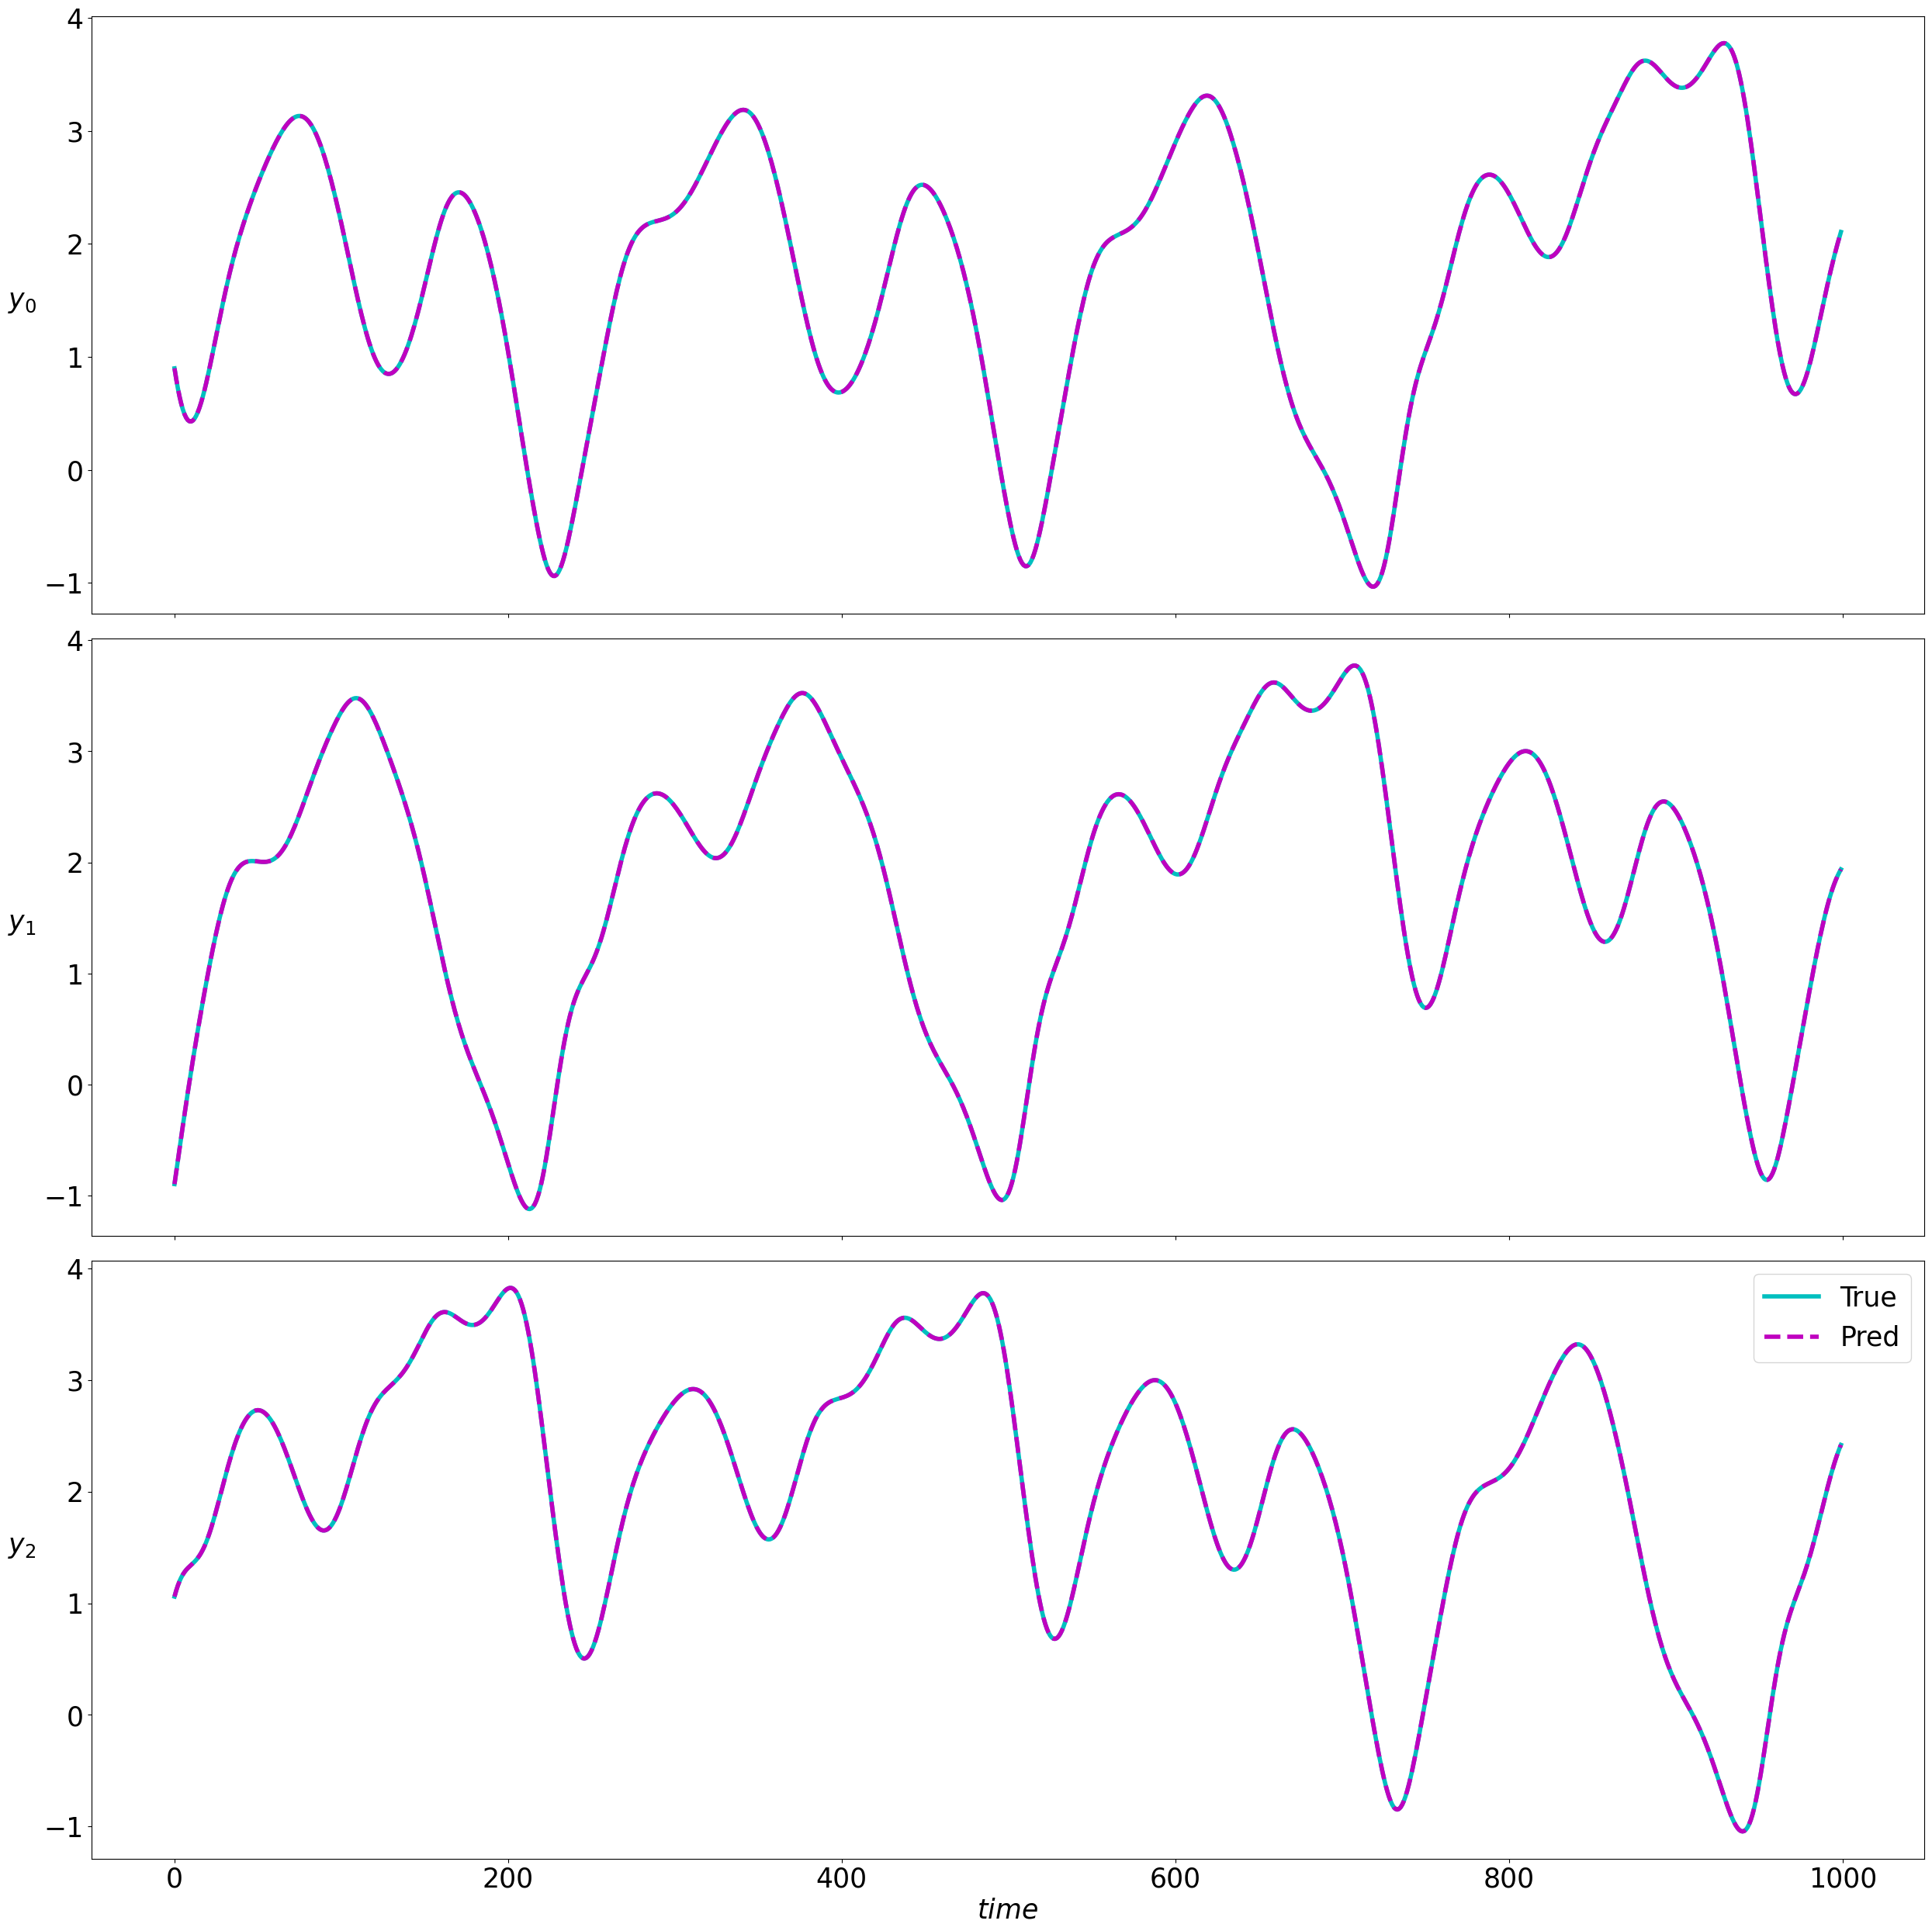

In [19]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()